rBergomi: variance reduction tests
==

$$S_t = \mathcal{E} \left\{ \int_0^t \sqrt{ V_u } \ \mathrm{d} \ (\rho W^1_u + \bar{\rho} W^2_u) \right\}, \quad V_t = \xi \ \mathcal{E} \left\{ \eta \sqrt{2\alpha + 1} \int_0^t (t - u)^\alpha \mathrm{d}W^1_u \right\},$$

CAREFUL WITH WHERE DATA FILES ARE KEPT FOR THIS, BEST TO CHANGE SURFACE CODE TEMPORARILY.
MUST GIVE BIAS AND STANDARD DEVIATION ON CHARTS!

In [1]:
import os
os.chdir('/Users/ryanmccrickerd/desktop/phd/2016-17/turbo_rbergomi/rbergomi')

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
from rbergomi import rBergomi
from surface import Surface
from routines import *
% matplotlib inline

This should come out with a similar phi to 0.24, if everything is understood.

In [3]:
n1 = 20500 # paths
N1 = 1000 # samples
rho = -0.0
### SELECT ESTIMATOR ########################
estimator = 'Base'
# estimator = 'Antithetic'
# estimator = 'Conditional'
# estimator = 'Controlled'
# estimator = 'Mixed'
#############################################
method_dict = {'Base':base_run,
               'Antithetic':base_run,
               'Conditional':conditional_mc, # optimise before using!
               'Controlled':timer_control,
               'Mixed':optimal_run}
method = method_dict[estimator]
method

<function routines.base_run>

In [4]:
### SELECT AS SAMPLING ########################
### ALWAYS SELECT AS !!! ######################
AS = True
# AS = False
if estimator == 'Base':
    AS = False
    
if estimator == 'Conditional' or estimator == 'Mixed':
    n1 = int(2*n1)

rbergomi = rBergomi(n = 8, N = n1, T = 0.25, a = -0.43, AS = AS)

if estimator == 'Conditional' or estimator == 'Mixed':
    n1 = int(n1/2)

In [5]:
### SELECT DATA ##############################

data_dict = {'-0.9':'base',
             '-0.0':'rho'}
data = data_dict[str(rho)]
surface = Surface('3m', data, close = False)
surface.surface

,10P,ATM,10C
3M,0.241656,0.217273,0.246561


In [6]:
surface._log_strike_surface()

,10P,ATM,10C
3M,-0.147548,0.0,0.165589


In [7]:
surface._put_deltas()

,10P,ATM,10C
3M,0.1,0.478341,0.9


In [8]:
### SELECT RHO #############################
kwargs = {'xi':0.235**2, 'eta':1.9, 'rho':rho}

Select implied vol construction here

In [9]:
np.random.seed(0)

In [10]:
%%timeit
IV = method(rbergomi, surface, **kwargs)
# Run this a few times so that libraries loaded.

1 loop, best of 3: 2.02 s per loop


In [11]:
from datetime import datetime

In [12]:
# trials = 10
# np.random.seed(0)
# IV = method(rbergomi, surface, **kwargs)
# t0 = datetime.now()
# for i in range(trials):
#     IV = method(rbergomi, surface, **kwargs)
# t1 = datetime.now()
# dt = (t1 - t0) / trials
# runtime = 1000 * (dt.seconds + dt.microseconds/1e6)
# runtime
# # runtime = np.round(dt.seconds + dt.microseconds/1e6, decimals = 3)

Recall must iterate input file vols to a fixed point. Use 250,000 antithetic paths for this.

In [13]:
# Set to 10000 with 50 buckets for final charts
replications = N1

In [14]:
# minutes = np.round(N1 * runtime / 1000 / 60, decimals = 1)
# print('Beware, the folling calculation will take ' + str(minutes) + ' minutes!')

This section should take the same amount of time for each. N should be scaled accordingly.

In [15]:
x = np.arange(replications)
y = 100 * np.squeeze(np.array(surface.surface)) # True implied vols
IV_observations = np.zeros((replications, 3))
np.random.seed(0)
t0 = datetime.now()
for i in range(replications):
    IV_observations[i,:] = method(rbergomi, surface, **kwargs)
#     if i%100 == 0:
#         print(i)

t1 = datetime.now()
dt = (t1 - t0) / N1
runtime = 1000 * (dt.seconds + dt.microseconds/1e6)
print('runtime is set to', np.round(runtime,1), 'milliseconds')

#     if IV_observations[i,0] < 0.01:
#         IV_observations[i,0] = y[0]/100.
#         i -= 1
k=0
for i in range(3):
    for j in range(replications):
        if IV_observations[j,i] < 0.01:
            IV_observations[j,i] = y[i]/100.
            k+=1
print(k)

runtime is set to 2177.6 milliseconds
0


Saved at: /Users/ryanmccrickerd/desktop/X4Y3_0_20500_1000_Base.png


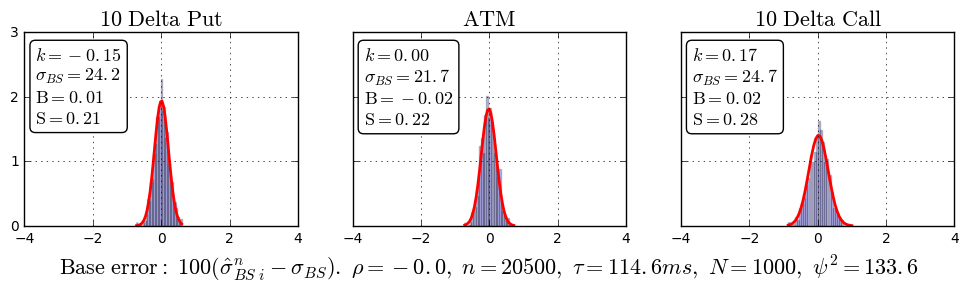

In [16]:
log_strikes = np.array(surface._log_strike_surface())[0]
IV_true = np.array(surface.surface)
IV_errors = IV_observations - IV_true
IV_errors *= 100
IV_mean = np.mean(IV_errors, axis = 0)
IV_std = np.std(IV_errors, axis = 0)
r = np.round(rho,2)
fs = 16
# Three subplots, unpack the axes array immediately
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey = True, sharex = True)

n, bins, patches = ax1.hist(IV_errors[:,0], 30, normed=100, fc='blue', ec='black', alpha=0.25, rwidth=0.9)

# add a 'best fit' line
norm_fit = mlab.normpdf(bins, IV_mean[0], IV_std[0])
ax1.plot(bins, norm_fit, 'r', linewidth = 2)

n, bins, patches = ax2.hist(IV_errors[:,1], 30, normed=100, fc='blue', ec='black', alpha=0.25, rwidth=0.9)

# add a 'best fit' line
norm_fit = mlab.normpdf(bins, IV_mean[1], IV_std[1])
ax2.plot(bins, norm_fit, 'r', linewidth = 2)

n, bins, patches = ax3.hist(IV_errors[:,2], 30, normed=100, fc='blue', ec='black', alpha=0.25, rwidth=0.9)

# add a 'best fit' line
norm_fit = mlab.normpdf(bins, IV_mean[2], IV_std[2])
ax3.plot(bins, norm_fit, 'r', linewidth = 2)

t = runtime
RM = runtime * np.sum(IV_std**2)/len(IV_std)
RMSE = np.sqrt(np.sum(IV_std**2)/len(IV_std))
# Set x and y axes labels
# if rho == 0:
#     ax1.set_ylabel(r'$\mathrm{Density}$', fontsize = 16)
if estimator == 'Base':
#     ax2.set_xlabel(r'$\mathrm{Base\ error:\ 100}( \hat{\sigma}^n_{BS\ i} - \sigma_{BS} ).\ \rho = %.1f,\ n = %.0f,\ \tau = %.1f ms,\ N = %.0f,\ \psi^2 = %.1f.}$'%(r, n1, t, N1, RM), fontsize = fs)
#     ax2.set_xlabel(r'$\mathrm{Base\ error:\ 100}( \hat{\sigma}^n_{BS\ i} - \sigma_{BS} ).\ \rho = %.1f,\ n = %.0f,\ \tau = 114.4ms,\ N = %.0f,\ \psi^2 = 131.4}$'%(r, n1, N1), fontsize = fs)
    ax2.set_xlabel(r'$\mathrm{Base\ error:\ 100}( \hat{\sigma}^n_{BS\ i} - \sigma_{BS} ).\ \rho = %.1f,\ n = %.0f,\ \tau = 114.6ms,\ N = %.0f,\ \psi^2 = 133.6}$'%(r, n1, N1), fontsize = fs)
elif estimator == 'Put':
    ax2.set_xlabel(r'$\mathrm{Put\ error:\ 100}( \hat{\sigma}^n_{BS\ i} - \sigma_{BS} ).\ \rho = %.1f,\ n = %.0f,\ \tau = %.1f ms,\ N = %.0f,\ \psi^2 = %.1f.}$'%(r, n1, t, N1, RM), fontsize = fs)
elif estimator == 'Antithetic':
    ax2.set_xlabel(r'$\mathrm{Antithetic\ error:\ 100}( \hat{\sigma}^n_{BS\ i} - \sigma_{BS} ).\ \rho = %.1f,\ n = %.0f,\ \tau = %.1f ms,\ N = %.0f,\ \psi^2 = %.1f.}$'%(r, n1, t, N1, RM), fontsize = fs)
elif estimator == 'Conditional':   
    ax2.set_xlabel(r'$\mathrm{Conditional\ error:\ 100}( \hat{\sigma}^n_{BS\ i} - \sigma_{BS} ).\ \rho = %.1f,\ n = %.0f,\ \tau = %.1f ms,\ N = %.0f,\ \psi^2 = %.1f.}$'%(r, n1, t, N1, RM), fontsize = fs)
elif estimator == 'Controlled':
    ax2.set_xlabel(r'$\mathrm{Controlled\ error:\ 100}( \hat{\sigma}^n_{BS\ i} - \sigma_{BS} ).\ \rho = %.1f,\ n = %.0f,\ \tau = %.1f ms,\ N = %.0f,\ \psi^2 = %.1f.}$'%(r, n1, t, N1, RM), fontsize = fs)
elif estimator == 'Mixed':
#     ax2.set_xlabel(r'$\mathrm{Mixed\ error:\ 100}( \hat{\sigma}^n_{BS\ i} - \sigma_{BS} ).\ \rho = %.1f,\ n = %.0f,\ \tau = %.1f ms,\ N = %.0f,\ \psi^2 = %.1f.}$'%(r, n1, t, N1, RM), fontsize = fs)
#     ax2.set_xlabel(r'$\mathrm{Mixed\ error:\ 100}( \hat{\sigma}^n_{BS\ i} - \sigma_{BS} ).\ \rho = %.1f,\ n = %.0f,\ \tau = 70.6ms,\ N = %.0f,\ \psi^2 = 10.4}$'%(r, n1, N1), fontsize = fs)
    ax2.set_xlabel(r'$\mathrm{Mixed\ error:\ 100}( \hat{\sigma}^n_{BS\ i} - \sigma_{BS} ).\ \rho = %.1f,\ n = %.0f,\ \tau = 69.8ms,\ N = %.0f,\ \psi^2 = 3.9}$'%(r, n1, N1), fontsize = fs)
# else:
#     ax1.set_ylabel(r'$\mathrm{Density}$', fontsize = 16)

# Set titles
# if rho == -0.9:
ax1.set_title(r'$\mathrm{10\ Delta \ Put}$', fontsize = fs)
ax2.set_title(r'$\mathrm{ATM}$', fontsize = fs)
ax3.set_title(r'$\mathrm{10\ Delta \ Call}$', fontsize = fs)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white')

b = np.round(IV_mean[0],2)
s = np.round(IV_std[0],2)
k = np.round(log_strikes[0],2)
IV = 100*IV_true[0][0]
textstr = '$k=%.2f$\n$\sigma_{BS}=%.1f$\n$\mathrm{B}=%.2f$\n$\mathrm{S}=%.2f$'%(k, IV, b, s)
# textstr = '$n=%.0E$\n$N=%.0E$\n$\\rho=%.2f$\n$k=%.2f$\n$\mathrm{B}=%.2f$\n$\mathrm{S}=%.2f$'%(n1, N1, r, k, b, s)

# textstr = 'a'

# place a text box in upper left in axes coords
ax1.text(0.04, 0.93, textstr, transform=ax1.transAxes, fontsize=13,
        va='top', ha='left', bbox=props)

b = np.round(IV_mean[1],2)
s = np.round(IV_std[1],2)
k = np.round(log_strikes[1],2)
IV = 100*IV_true[0][1]
textstr = '$k=%.2f$\n$\sigma_{BS}=%.1f$\n$\mathrm{B}=%.2f$\n$\mathrm{S}=%.2f$'%(k, IV, b, s)

# place a text box in upper left in axes coords
ax2.text(0.04, 0.93, textstr, transform=ax2.transAxes, fontsize=13,
        va='top', ha='left', bbox=props)

b = np.round(IV_mean[2],2)
s = np.round(IV_std[2],2)
k = np.round(log_strikes[2],2)
IV = 100*IV_true[0][2]
textstr = '$k=%.2f$\n$\sigma_{BS}=%.1f$\n$\mathrm{B}=%.2f$\n$\mathrm{S}=%.2f$'%(k, IV, b, s)

# place a text box in upper left in axes coords
ax3.text(0.04, 0.93, textstr, transform=ax3.transAxes, fontsize=13,
        va='top', ha='left', bbox=props)

# Apply grids
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)

# Remove meaningless y axis densities
# ax1.yaxis.set_visible(False)
# ax2.yaxis.set_visible(False)
# ax3.yaxis.set_visible(False)

# ax2.xaxis.set_ticks(np.linspace(-2,2,5))
# ax3.xaxis.set_ticks(np.linspace(-2,2,5))

# ax1.set_ylim([0,7])
#ax1.set_ylim([0,4])

# for tick in ax1.xaxis.get_major_ticks():
#     tick.label.set_fontsize(12)
# for tick in ax2.xaxis.get_major_ticks():
#     tick.label.set_fontsize(12)
# for tick in ax3.xaxis.get_major_ticks():
#     tick.label.set_fontsize(12)
f.set_size_inches(12, 2.5)
save_path = '/Users/ryanmccrickerd/desktop/'

# for x in [1,2,4]:
#     for y in [1,2,3,4]:
for x in [4]:
    for y in [3]:        
        ax1.set_xlim([-x,x])
        ax1.xaxis.set_ticks(np.linspace(-x,x,5))
        ax1.set_ylim([0,y])
        ax1.yaxis.set_ticks(np.linspace(0,y,y+1))
        fig_name = 'X'+str(x) +'Y'+str(y) +'_'+ str(rho)[-1] +'_'+ str(n1) +'_'+ str(N1) +'_'+ estimator
        # plt.gcf().subplots_adjust(bottom=0.16)
        fname = save_path + fig_name + '.png'
        f.savefig(fname, bbox_inches='tight')
        print('Saved at:', fname)
    
# fname = '/Users/ryanmccrickerd/Desktop/phd/2017-18/turbo/histogram3.pdf'
# plt.savefig(fname, dpi=300, bbox_inches='tight')

Need to place Y scale in file names too ! Defined by highest in optimal case. looks like 3.

In [17]:
IV_true[0][0]

0.24165647564612899

In [18]:
# print('Means =', IV_mean)
# print('Stds =', IV_std)

In [19]:
# import cProfile

In [20]:
# pr = cProfile.Profile()
# pr.run('method(rbergomi, surface, **kwargs)')

In [21]:
# pr.print_stats(sort='cumtime')

In [22]:
full_surface = Surface('3m_full', data, close = False)
full_surface.surface

,5P,10P,15P,20P,25P,30P,35P,40P,45P,ATM,45C,40C,35C,30C,25C,20C,15C,10C,5C
3M,0.257699,0.241656,0.233083,0.227538,0.223711,0.221002,0.219143,0.217949,0.217362,0.217273,0.217839,0.218903,0.220575,0.22293,0.226165,0.230622,0.236906,0.246561,0.264556


Saved at: /Users/ryanmccrickerd/desktop/0_20500_1000_Base.png


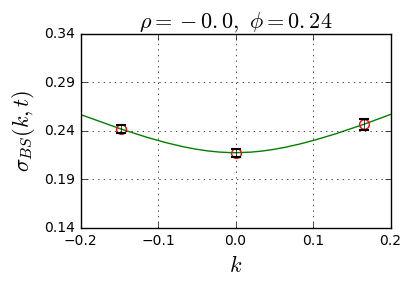

In [23]:
k_full = np.array(full_surface._log_strike_surface())
MV_full = np.array(full_surface.surface)
k = np.array(surface._log_strike_surface())

means = np.array(surface.surface) + IV_mean/100
lower = means + 2*IV_std/100
upper = means - 2*IV_std/100

plot, axes = plt.subplots(figsize=(4,2.5))

# axes.plot(k[0,:], MV[0,:], 'r')
# axes.plot(k[1,:], MV[1,:], 'm')
# axes.plot(k[2,:], MV[2,:], 'y')
axes.plot(k_full[0,:], MV_full[0,:], 'g')
axes.plot(k[0,:], means[0,:], 'ro', fillstyle = 'none', ms = 7, mew = 1)
axes.plot(k[0,:], lower[0,:], 'k_', fillstyle = 'none', ms = 7, mew = 1.5)
axes.plot(k[0,:], upper[0,:], 'k_', fillstyle = 'none', ms = 7, mew = 1.5)
for i in range(3):
    axes.plot([k[0,i],k[0,i]], [lower[0,i],upper[0,i]], 'k', linewidth = 0.5)
# axes.plot(k[4,:], MV[4,:], 'c')
# axes.plot(k[5,:], MV[5,:], 'b')

axes.set_xlabel(r'$k$', fontsize = 16)
axes.set_ylabel(r'$\sigma_{BS}(k,t)$', fontsize = 16)
axes.set_title(r'$\rho = %.1f,\ \phi = %.2f}$'%(r,RMSE), fontsize = 16)
# axes.legend([r'$\mathsf{3M}$'], prop={'size':11}, loc=3)
if r == 0:    
    xlim = 0.2
    plt.xlim([-xlim,xlim])
    axes.xaxis.set_ticks(np.linspace(-xlim,xlim,5))
    plt.ylim([0.14,0.3401])
    axes.yaxis.set_ticks(np.linspace(0.14,0.34,5))
else:
    plt.xlim([-0.25,0.15])
    axes.xaxis.set_ticks(np.linspace(-0.25,0.15,5))
    plt.ylim([0.14,0.3401])
    axes.yaxis.set_ticks(np.linspace(0.14,0.34,5))
plt.grid(True)

save_path = '/Users/ryanmccrickerd/desktop/'
fig_name = str(rho)[-1] +'_'+ str(n1) +'_'+ str(N1) +'_'+ estimator
fname = save_path + fig_name + '.png'
plot.savefig(fname, bbox_inches='tight')
print('Saved at:', fname)

fname = '/Users/ryanmccrickerd/Desktop/phd/2017-18/turbo/bounds5.pdf'
plt.savefig(fname, dpi=300, bbox_inches='tight')